# Exercises

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

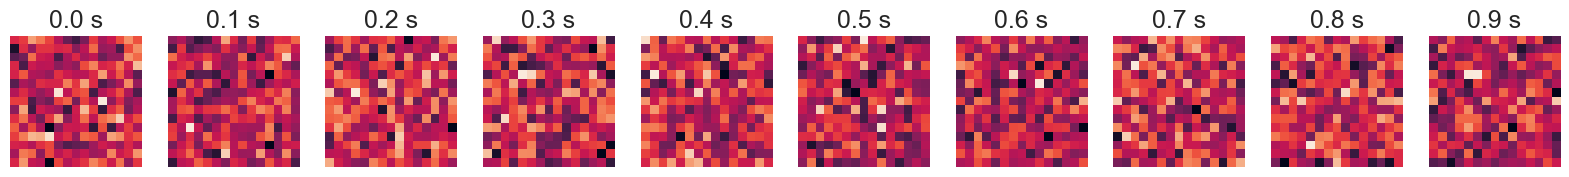

In [2]:
durations = [5., 10., 20., 40., 80., 160., 320., 640.]

def generate_stimuli(duration, dt = .1, std_dev = 1, vf_size = (15,15)):
    n_bins = round(duration / float(dt))
    S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
    return S

S = generate_stimuli(50.)

# plot the first second of stimuli
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(S[i])
    plt.axis('off')
    plt.title(f'0.{i} s')

Text(0, 0.5, 'y')

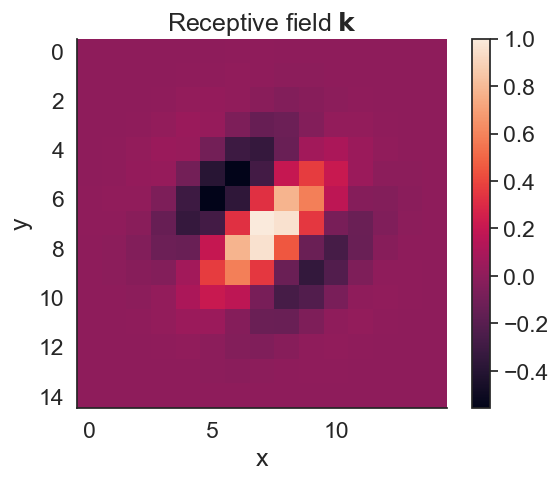

In [3]:
def gabor_filter(size = (15,15), # size in pixel of our receptive field
                 mu = (8, 8), # center of the gabor patch 
                 sigma = (4,4), #size of the gabor patch
                 angle = 45, # orientation of the gabor patch
                 frequency = .085, # spatial frequency of the gabor patch
                 phase = 0): # phase of the gabor patch
    xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))
    # Gaussian envelope
    G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0]) - np.power(yy - mu[1], 2) / (2. * sigma[1]))
    # spatial modulation
    phi = np.deg2rad(angle)
    xxr = xx * np.cos(phi)
    yyr = yy * np.sin(phi)
    xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
    Sn = np.cos(xyr + phase)
    K = G * Sn
    K /= np.amax(np.abs(K))
    return K

K = gabor_filter()

plt.imshow(K)
plt.title(r'Receptive field $\bf{k}$')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

In [4]:
def generate_response(K, 
                      S, 
                      noise_variance = 1, 
                      offset = 2, 
                      dt = .1):
    n_bins = S.shape[0]
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    
    ks = np.dot(K_flat, S_flat.T)
    rate = ks
    rate = rate + np.sqrt(noise_variance) * np.random.randn(S_flat.shape[0])

    return ks, rate, S_flat

In [5]:
def pearson(K_true, K_est):
    return np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))

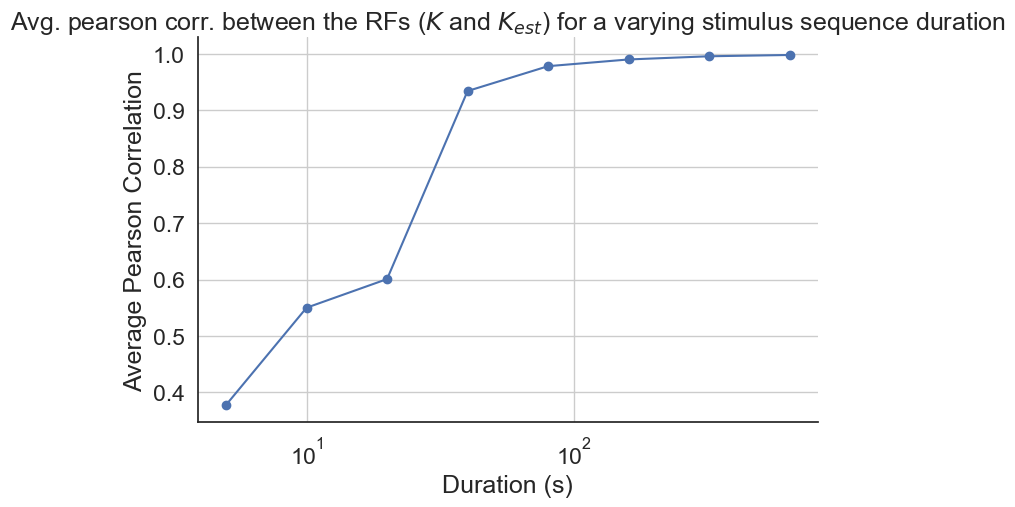

In [6]:
def calc_correlations(durations):
    correlations = []
    
    K_true = gabor_filter()
    
    for i, duration in enumerate(durations):
        ccs = []
        for j in range(10):
            S = generate_stimuli(duration)
            
            ks, rate, S_flat = generate_response(K_true, S)
            
            K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
            
            cc = pearson(K_true, K_hat)
            ccs.append(cc)

        correlations.append(np.mean(ccs))
        
    return correlations

durations = [5., 10., 20., 40., 80., 160., 320., 640.]
correlations = calc_correlations(durations)

plt.figure(figsize=(8, 5))
plt.plot(durations, correlations, marker='o')
plt.xscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Average Pearson Correlation')
plt.title('Avg. pearson corr. between the RFs ($K$ and $K_{est}$) for a varying stimulus sequence duration')
plt.grid(True)
plt.show()

The pearson correlation between the true RF and the estimated RF seems to reach the theoretical limit of 1 as the duration of the stimulus sequence increases. The increase in correlation is gradual and on the logarithmic scale. So depending on the increase in duration the pearson correlation increases, meaning a bigger increase at lower durations and a smaller increase as the duration gets larger on an absolute scale. Since the steps between the durations are doublings or powers of 2.
Oddly enough, there seems to be a small decrease in the steepness of the graph, at around 20 seconds.

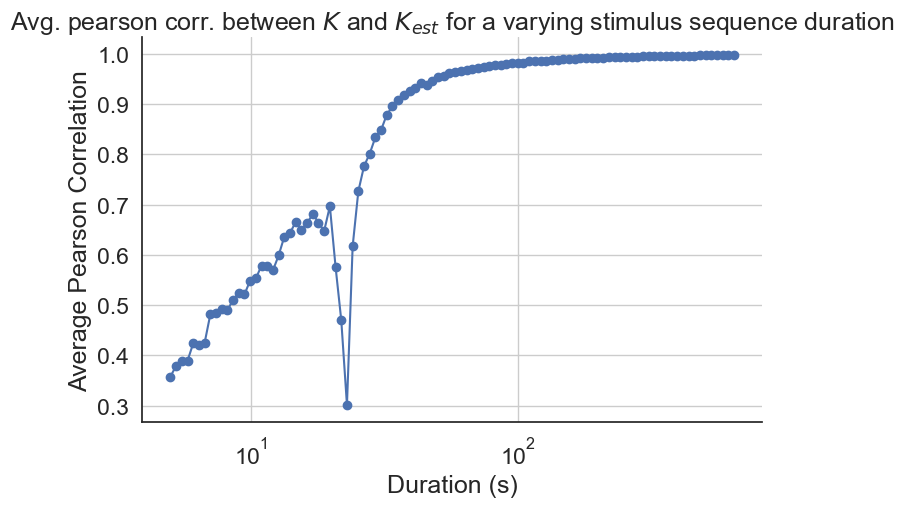

In [7]:
# to get more or less plot points you can change the durations array
nr_of_points = 100 # 8 will give the same input variables as before
durations =  np.logspace(np.log2(5),np.log2(640), nr_of_points, base = 2)

correlations = calc_correlations(durations)

plt.figure(figsize=(8, 5))
plt.plot(durations, correlations, marker='o')
plt.xscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Average Pearson Correlation')
plt.title('Avg. pearson corr. between $K$ and $K_{est}$ for a varying stimulus sequence duration')
plt.grid(True)
plt.show()

In [8]:
index = np.argmin(correlations)
print(index)
print(durations[index], "s")

31
22.84564527328583 s


Plotting more data points we even more clearly see that theres a dip in the graph around the same dip we saw in the earlier graph. It seems a bit odd and maybe its an error somewhere in the code, but I could not find it. 

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 